
The ``Smarket'' dataset contains a 1250 days of S&P 500 index percentage returns. The data dictionary is as follows:
* Year: year of the return
* Lag1 - Lag5: 1 to 5 days lagged returns
* Volume: the number of shares traded on the previous day (in billions)
* Today: the percentage return on the day in question
* Direction: whether the return was positive or negative on the day in question

Create a training dataset of all days from 2004 and earlier. The test set is data from 2005.

1. Create a function to calculate the return on an investment of dollar value x over the entire dataset, invested before the first day in the dataset.
2. Create a function to calculate the return on an investment of dollar value x at the end of the day in question, if invested before the day in question began (i.e. before the percentage return was known).
3. Create and analyze a linear regression model to predict the percentage return. 
4.Create and analyze a logistic regression model to predict whether the return will be positive or negative.ositive or negative.
5. Create a function to calculate the total return on an initial investment of dollar value x made using a few simple trading schemes:
    * at the beginning of any day, if you expect the percentage return to be positive, invest all of the money currently on hand, otherwise do not invest for the upcoming day.
    * at the beginning of any day, if you expect the percentage return to be greater than y%, invest all of the money currently on hand, otherwise do not invest for the upcoming day.
        * vary y and report your results.
    * how would you improve the above strategies?
    * how did you select the threshold for prediction with your logistic regression model?
    * how does threshold selection on the logistic regression model predictions differ from the selection of y?
    * remember that money currently on hand takes into account all past gains and losses as well as the initial investment
    * what is your best strategy?



In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols, logit
from sklearn.model_selection import train_test_split
import scipy.stats as ss
import seaborn as sns
from itertools import product


from ISLP import load_data
Smarket = load_data('Smarket')
#Smarket

In [107]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Display the dataset
#print(Smarket)

In [108]:
# split train and test data 

In [109]:
train_data = Smarket[Smarket['Year'] < 2005]
test_data = Smarket[Smarket['Year'] == 2005]

# Display the number of rows in each dataset
print("Training data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

# Optionally, display the first few rows of each dataset
print("\nTraining Data (2004 and earlier):\n", train_data.head())
print("\nTest Data (2005):\n", test_data.head())

Training data shape: (998, 9)
Test data shape: (252, 9)

Training Data (2004 and earlier):
    Year   Lag1   Lag2   Lag3   Lag4   Lag5  Volume  Today Direction
0  2001  0.381 -0.192 -2.624 -1.055  5.010  1.1913  0.959        Up
1  2001  0.959  0.381 -0.192 -2.624 -1.055  1.2965  1.032        Up
2  2001  1.032  0.959  0.381 -0.192 -2.624  1.4112 -0.623      Down
3  2001 -0.623  1.032  0.959  0.381 -0.192  1.2760  0.614        Up
4  2001  0.614 -0.623  1.032  0.959  0.381  1.2057  0.213        Up

Test Data (2005):
       Year   Lag1   Lag2   Lag3   Lag4   Lag5  Volume  Today Direction
998   2005 -0.134  0.008 -0.007  0.715 -0.431  0.7869 -0.812      Down
999   2005 -0.812 -0.134  0.008 -0.007  0.715  1.5108 -1.167      Down
1000  2005 -1.167 -0.812 -0.134  0.008 -0.007  1.7210 -0.363      Down
1001  2005 -0.363 -1.167 -0.812 -0.134  0.008  1.7389  0.351        Up
1002  2005  0.351 -0.363 -1.167 -0.812 -0.134  1.5691 -0.143      Down


In [110]:
#QUESTION 1 - Create a function to calculate the return on an investment of dollar value x over the entire dataset, invested before the first day in the dataset.

def calculate_total_investment_return(data, initial_investment_amount):

    # Convert daily percentage returns to numerical format 
    daily_percentage_returns = data['Today'] / 100
    
    # Compute cumulative return factor: (1 + daily_return) for each day
    cumulative_return_factors = (1 + daily_percentage_returns).cumprod()
   
    # Calculate the final value of the investment based on the cumulative return factor
    final_investment_value = initial_investment_amount * cumulative_return_factors.iloc[-1]
    
    return final_investment_value

# Example usage:
initial_investment_amount = 1000  # Example: $1000

# Calculate the total return on the investment over the entire dataset
final_investment_value = calculate_total_investment_return(Smarket, initial_investment_amount)

print(f"The final value of an initial investment of ${initial_investment_amount} is: ${final_investment_value:.2f}")


The final value of an initial investment of $1000 is: $959.53


In [111]:
#QUESTION 2 - Create a function to calculate the return on an investment of dollar value x at the end of the day in question, if invested before the day in question began (i.e. before the percentage return was known).

def calculate_return_on_investment(data, investment_value, day_index):
    # Ensure the day_index is within the bounds of the dataset
    if day_index < 0 or day_index >= len(data):
        raise IndexError("Day index is out of range.")
    
    # Investment is made before the percentage return for that day is known
    # so we use the return for that day to compute the end value
    daily_return = data['Today'].iloc[day_index] / 100
    final_value = investment_value * (1 + daily_return)
    
    return final_value

# Example usage:
investment_value = 1000  # Initial investment amount

# Calculate the return for the first 10 days as an example
#for day_index in range(10):
day_index=10
day_index-=1
final_value = calculate_return_on_investment(Smarket, investment_value, day_index)
print(f"Day {day_index+1}: Initial Investment = ${investment_value}, Final Value = ${final_value:.2f}")


Day 10: Initial Investment = $1000, Final Value = $1002.87


In [112]:
# QUESTION 3 - Create and analyze a linear regression model to predict the percentage return.

import pandas as pd
from ISLP import load_data
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

# Load the dataset
Smarket = load_data('Smarket')

# Filter the data
train_data = Smarket[Smarket['Year'] <= 2004]
test_data = Smarket[Smarket['Year'] == 2005]

# Features and target variable
features = ['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume']
X_train = train_data[features]
y_train = train_data['Today']

# Add constant to the training features
X_train = sm.add_constant(X_train)

# Initialize and fit the OLS model using statsmodels
ols_model = sm.OLS(y_train, X_train).fit()

# Prepare the test data
X_test = test_data[features]  # Select features for the test set
y_test = test_data['Today']   # Actual values for comparison

# Add constant to the test features
X_test = sm.add_constant(X_test)

# Predict the 'Today' variable using the OLS model
y_pred = ols_model.predict(X_test)

# Print predicted values and compare with actual
print("Predicted values:", y_pred.values)
#print("Actual values:", y_test.values)

#summary
print(ols_model.summary())

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the performance metrics
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")


Predicted values: [ 9.68737668e-03 -6.99824466e-03  3.90222115e-02  2.79839617e-02
  1.29177056e-02  4.12978348e-02  4.29475800e-02  2.41823001e-02
 -1.36499262e-02  2.22496576e-02 -1.49086683e-02  1.97722804e-04
 -1.28110215e-04  5.82644380e-02 -5.82723373e-04 -1.35161658e-02
  4.23820560e-02  2.43810796e-02  2.31346912e-02  1.89482420e-02
 -3.03414735e-02 -3.83446806e-02 -1.43062362e-02  8.63961739e-03
 -5.59561953e-02 -3.71288030e-02 -1.33512353e-02  2.49255300e-02
 -4.12141465e-02 -1.00063370e-02 -7.32804148e-03  2.33797881e-02
 -2.29634233e-02 -8.92766651e-03  4.59717432e-03  2.49735266e-02
  8.90831527e-03  1.46853585e-02 -2.22697851e-02  6.05653776e-02
 -3.11453329e-02 -3.71928559e-02 -3.18748502e-02  4.20954156e-03
 -3.62225297e-02  7.61376324e-03  2.35895502e-02 -2.80423287e-02
  1.18746251e-02  2.14645634e-02  5.40793653e-02  2.45136503e-02
  3.64936119e-02 -4.58995023e-03  5.05745827e-02  6.70452307e-02
  1.42702654e-02  1.39037592e-02  2.56783557e-02  6.39796368e-02
 -1.633

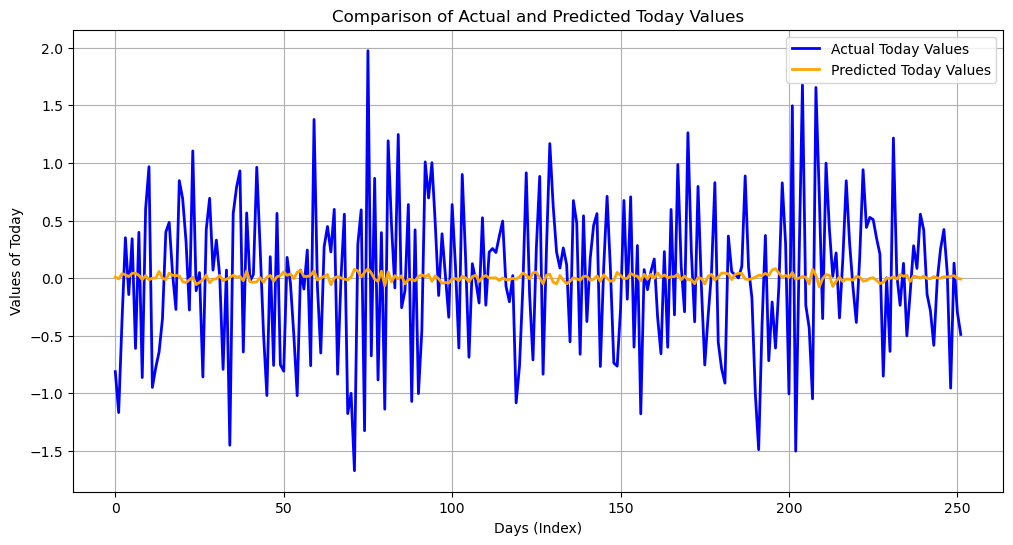

In [113]:
#Comparison of Actual and Predicted Today Values
plt.figure(figsize=(12, 6))
plt.plot(y_test.reset_index(drop=True), color='blue', label='Actual Today Values', linewidth=2)
plt.plot(y_pred.reset_index(drop=True), color='orange', label='Predicted Today Values', linewidth=2)
plt.title('Comparison of Actual and Predicted Today Values')
plt.xlabel('Days (Index)')
plt.ylabel('Values of Today')
plt.legend()
plt.grid(True)
plt.show()

Polynomial Mean Squared Error: 0.77
Polynomial R-squared: -0.84


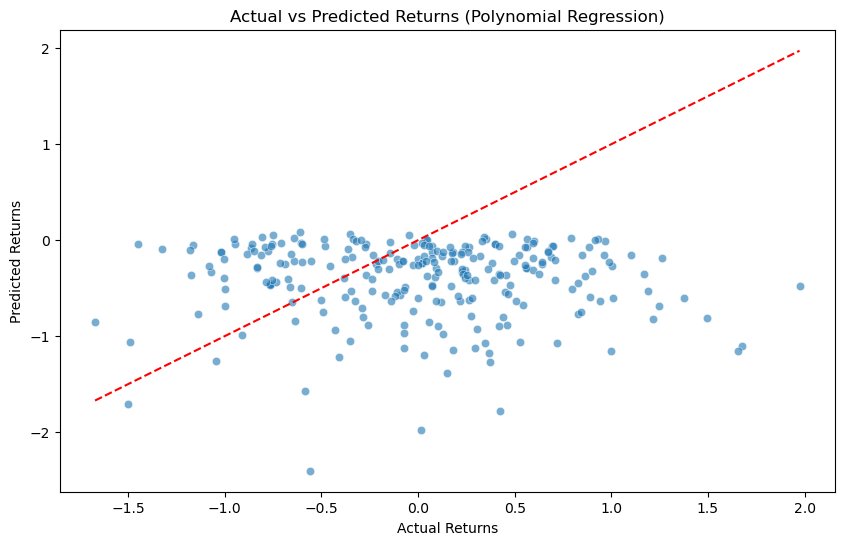

In [114]:
#Polynomial Regression 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Feature Engineering: Add polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Fit the polynomial regression model
model_poly = LinearRegression()
model_poly.fit(X_train_poly, y_train)

# Predict and evaluate
y_pred_poly = model_poly.predict(X_test_poly)
mse_poly = mean_squared_error(y_test, y_pred_poly)
r2_poly = r2_score(y_test, y_pred_poly)

print(f"Polynomial Mean Squared Error: {mse_poly:.2f}")
print(f"Polynomial R-squared: {r2_poly:.2f}")

# Plotting actual vs predicted values for polynomial regression
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_poly, alpha=0.6)
plt.xlabel('Actual Returns')
plt.ylabel('Predicted Returns')
plt.title('Actual vs Predicted Returns (Polynomial Regression)')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.show()


In [115]:
#OUESTION 4 - Create and analyze a logistic regression model to predict whether the return will be positive or negative.

import pandas as pd
from ISLP import load_data
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
Smarket = load_data('Smarket')

# Create binary target variable: 1 if 'Today' > 0 (positive return), 0 otherwise
Smarket['PositiveReturn'] = (Smarket['Today'] > 0).astype(int)
# Filter the data
train_data = Smarket[Smarket['Year'] <= 2004]
test_data = Smarket[Smarket['Year'] == 2005]

# Features and target variable
features = ['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume']
X_train = train_data[features]
y_train = train_data['PositiveReturn']
X_test = test_data[features]
y_test = test_data['PositiveReturn']

# Fit the Model
# Initialize and fit the logistic regression model
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)

# Predict probabilities on the test set
y_probs = logistic_model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

# Set a custom threshold
custom_threshold = 0.5

# Predict based on the custom threshold
y_pred_custom = (y_probs >= custom_threshold).astype(int)

# Performance metrics
accuracy = accuracy_score(y_test, y_pred_custom)
conf_matrix = confusion_matrix(y_test, y_pred_custom)
class_report = classification_report(y_test, y_pred_custom)

print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)


Accuracy: 0.48
Confusion Matrix:
[[ 81  30]
 [101  40]]
Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.73      0.55       111
           1       0.57      0.28      0.38       141

    accuracy                           0.48       252
   macro avg       0.51      0.51      0.47       252
weighted avg       0.52      0.48      0.46       252



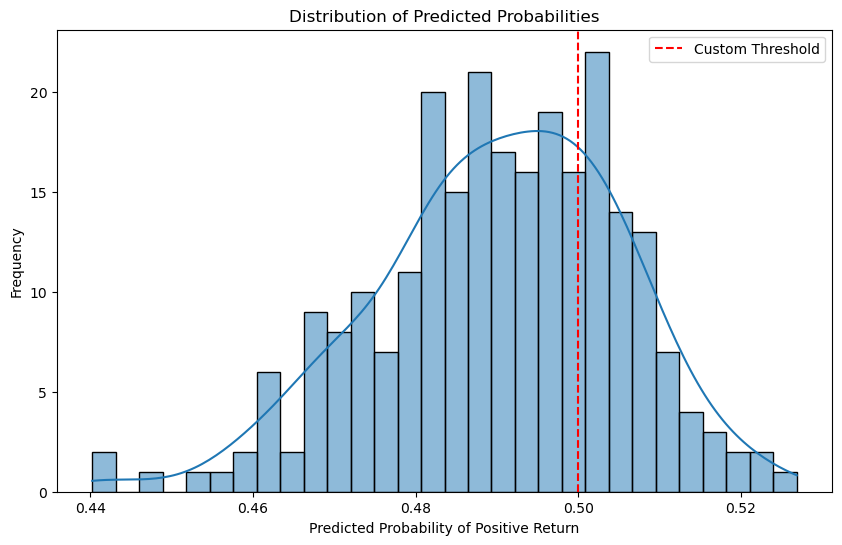

In [116]:
# Optional: Visualization of predicted probabilities
plt.figure(figsize=(10, 6))
sns.histplot(y_probs, bins=30, kde=True)
plt.axvline(x=custom_threshold, color='red', linestyle='--', label='Custom Threshold')
plt.xlabel('Predicted Probability of Positive Return')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities')
plt.legend()
plt.show()


Model Coefficients:
        Coefficient
Lag1      -0.059062
Lag2      -0.042119
Lag3       0.008779
Lag4       0.000466
Lag5      -0.004212
Volume    -0.120205


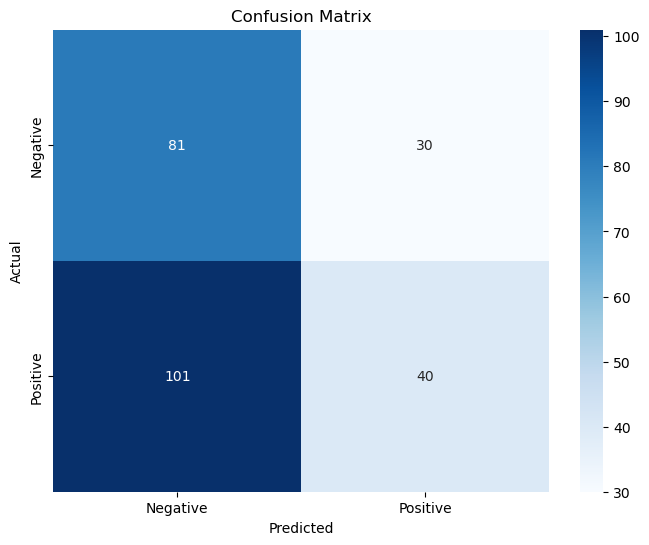

In [117]:
# Analyze Results
# Model coefficients
coefficients = pd.DataFrame(logistic_model.coef_[0], features, columns=['Coefficient'])
print("Model Coefficients:")
print(coefficients)

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [118]:
import statsmodels.api as sm

# Add a constant to the features matrix (for the intercept)
X_train_with_const = sm.add_constant(X_train)

# Fit the logistic regression model
logit_model = sm.Logit(y_train, X_train_with_const)
logit_result = logit_model.fit()

# Print the summary
print(logit_result.summary())


Optimization terminated successfully.
         Current function value: 0.691898
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:         PositiveReturn   No. Observations:                  998
Model:                          Logit   Df Residuals:                      991
Method:                           MLE   Df Model:                            6
Date:                Wed, 25 Sep 2024   Pseudo R-squ.:                0.001660
Time:                        17:50:51   Log-Likelihood:                -690.51
converged:                       True   LL-Null:                       -691.66
Covariance Type:            nonrobust   LLR p-value:                    0.8905
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2015      0.334      0.604      0.546      -0.453       0.856
Lag1          -0.0592      0.

5. Create a function to calculate the total return on an initial investment of dollar value x made using a few simple trading schemes:
   * at the beginning of any day, if you expect the percentage return to be positive, invest all of the money currently on hand, otherwise do not invest for the upcoming day.

In [119]:
def trading_strategy(data, initial_investment=1000, day_return=0):
    cash = initial_investment  # Start with the initial investment
    for i, row in data.iterrows():
        # If expected return (Today) is greater than the threshold
        if row['Today'] > day_return:
            # Invest all money, multiplying by the return percentage
            cash *= (1 + row['Today'] / 100)
    return cash
final_cash_0_return = trading_strategy(Smarket, day_return=0)
print(f"Final cash with 0% day return: ${final_cash_0_return:.2f}")

Final cash with 0% day return: $174605.77


Q.At the beginning of any day, if you expect the percentage return to be greater than y%, invest all of the money currently on hand, otherwise do not invest for the upcoming day.

In [120]:
def trading_strategy_varying_y(data, initial_investment=1000, y_value=0):
    # Execute the trading strategy with a single threshold value
    final_cash = trading_strategy(data, initial_investment, y_value)
    return y_value, final_cash

# Test with a specific threshold value for y:
y_value = 0.5  # Test threshold of +0.5%
y, final_cash = trading_strategy_varying_y(Smarket, initial_investment=1000, y_value=y_value)

# Print the result for the single threshold
print(f"Final cash with {y}% threshold: ${final_cash:.2f}")


Final cash with 0.5% threshold: $89398.31


In [121]:
# * vary y and report your results.

In [122]:
def trading_strategy_varying_y(data, initial_investment=1000, y_values=[0]):
    results = []
    for y in y_values:
        final_cash = trading_strategy(data, initial_investment, y)
        results.append((y, final_cash))
    return results

In [123]:
# Now let's try a range of thresholds for y:
y_values = [-2, -1, 0, 1, 2]  # Test thresholds of -2%, -1%, 0%, +1%, +2%
results = trading_strategy_varying_y(test_data, initial_investment=1000, y_values=y_values)

# Print results for different thresholds
for y, final_cash in results:
    print(f"Final cash with {y}% threshold: ${final_cash:.2f}")

Final cash with -2% threshold: $1029.95
Final cash with -1% threshold: $1263.96
Final cash with 0% threshold: $1943.64
Final cash with 1% threshold: $1188.39
Final cash with 2% threshold: $1000.00


#how would you improve the above strategies?

Adaptive Thresholds (Dynamic y)
Volatility-Based Adjustments: Instead of using a static threshold, adjust y based on the market's volatility. For instance, in more volatile markets, a wider y range may be necessary, while in calm markets, a tighter y threshold would be appropriate. Volatility measures like the standard deviation or average true range (ATR) can guide this.
Moving Average or Trend Indicators: Use moving averages or other trend-following indicators to dynamically adjust y. For example, if the market is in an uptrend (determined by the slope of the moving average), set a more aggressive y threshold, and if the market is flat or down, reduce the threshold.

In [124]:
# how did you select the threshold for prediction with your logistic regression model?

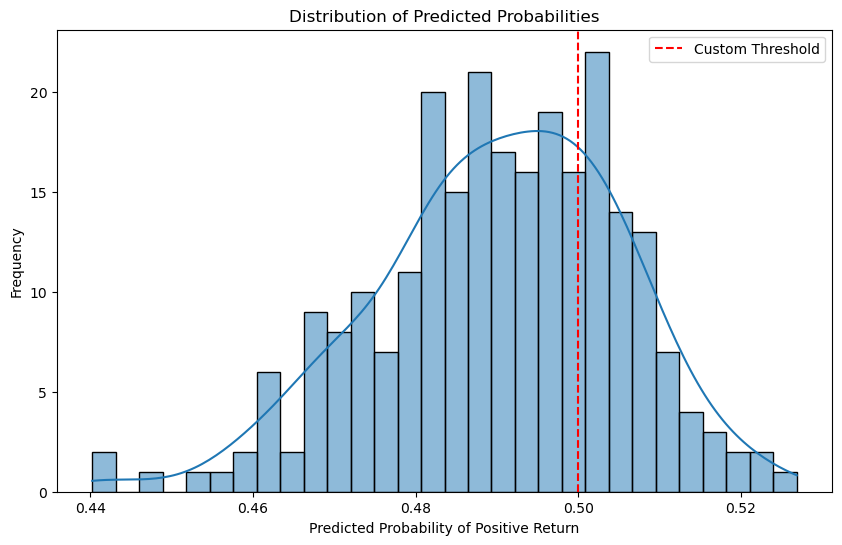

In [125]:
# Optional: Visualization of predicted probabilities
plt.figure(figsize=(10, 6))
sns.histplot(y_probs, bins=30, kde=True)
plt.axvline(x=custom_threshold, color='red', linestyle='--', label='Custom Threshold')
plt.xlabel('Predicted Probability of Positive Return')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities')
plt.legend()
plt.show()
